In [5]:
pip install pandas scikit-learn xgboost xmltodict

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd 
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import xml.etree.ElementTree as ET 
from datetime import datetime 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing  import StandardScaler 
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error

In [7]:
# Insulin absorption model
def insulin_absorption(I, t, params):
    I_sc1, I_sc2, I_p = I
    k_d, k_a2, k_e, V_I, beta = params
    
    # Delayed insulin and its progression
    dI_sc1_dt = -k_d * I_sc1 + I_p / V_I
    dI_sc2_dt = k_d * I_sc1 - k_a2 * I_sc2
    dI_p_dt = k_a2 * I_sc2 - k_e * I_p
    
    return [dI_sc1_dt, dI_sc2_dt, dI_p_dt]


In [8]:
# Glucose absorption model
def glucose_absorption(Q, t, CHO, params):
    Q_sto1, Q_sto2, Q_gut = Q
    k_gri, k_empt, k_abs, f = params
    
    dQ_sto1_dt = -k_gri * Q_sto1 + CHO
    dQ_sto2_dt = k_gri * Q_sto1 - k_empt * Q_sto2
    dQ_gut_dt = k_empt * Q_sto2 - k_abs * Q_gut
    
    Ra = f * k_abs * Q_gut
    return [dQ_sto1_dt, dQ_sto2_dt, dQ_gut_dt], Ra


In [11]:
# Glucose-insulin kinetics
def glucose_insulin_kinetics(G, t, Ra, I_p, params):
    G_p, X, IG = G
    S_G, p2, SI, Gb, V_G, alpha = params
    
    G_p = min(G_p, 180)  # Clamping to prevent extreme glucose levels
    X = min(X, 180)
    IG = min(IG, 180)

    dG_p_dt = -(S_G + SI * X) * G_p + S_G * Gb + Ra / V_G
    dX_dt = -p2 * (X - SI * (I_p - Gb))
    dIG_dt = -1/alpha * (IG - G_p)
    
    return [dG_p_dt, dX_dt, dIG_dt]



In [12]:
# Combined system of equations
def model_system(state, t, I_input, CHO_input, insulin_params, glucose_params, kinetics_params):
    I_state = state[:3]  # Insulin state variables
    Q_state = state[3:6] # Glucose absorption variables
    G_state = state[6:]  # Glucose-insulin kinetics variables
    
    I_p = I_input(t)
    CHO = CHO_input(t)
    
    dI_state_dt = insulin_absorption(I_state, t, insulin_params)
    dQ_state_dt, Ra = glucose_absorption(Q_state, t, CHO, glucose_params)
    dG_state_dt = glucose_insulin_kinetics(G_state, t, Ra, I_p, kinetics_params)
    
    return np.concatenate([dI_state_dt, dQ_state_dt, dG_state_dt])


In [23]:
# Parse XML file for insulin and glucose events
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    basal_data, temp_basal_data, bolus_data, meal_data = [], [], [], []
    
    for basal_event in root.findall(".//basal/event"):
        timestamp = basal_event.get('ts')
        basal_value = float(basal_event.get('value'))
        basal_data.append((timestamp, basal_value))
    
    for temp_basal_event in root.findall(".//temp_basal/event"):
        ts_begin = temp_basal_event.get('ts_begin')
        ts_end = temp_basal_event.get('ts_end')
        temp_basal_value = float(temp_basal_event.get('value'))
        temp_basal_data.append((ts_begin, ts_end, temp_basal_value))
    
    for bolus_event in root.findall(".//bolus/event"):
        ts_begin = bolus_event.get('ts_begin')
        ts_end = bolus_event.get('ts_end')
        bolus_dose = float(bolus_event.get('dose'))
        bolus_data.append((ts_begin, ts_end, bolus_dose))
    
    for meal_event in root.findall(".//meal/event"):
        timestamp = meal_event.get('ts')
        carbs = float(meal_event.get('carbs'))
        meal_data.append((timestamp, carbs))
    
    return basal_data, temp_basal_data, bolus_data, meal_data



In [15]:
# Calculate insulin input from parsed data
def insulin_input(t, basal_data, temp_basal_data, bolus_data):
    insulin = 0
    for (timestamp, basal_value) in basal_data:
        time_in_minutes = time_to_minutes(timestamp, start_time)
        if t >= time_in_minutes:
            insulin += basal_value
    
    for (ts_begin, ts_end, temp_basal_value) in temp_basal_data:
        time_start = time_to_minutes(ts_begin, start_time)
        time_end = time_to_minutes(ts_end, start_time)
        if time_start <= t <= time_end:
            insulin += temp_basal_value
    
    for (ts_begin, ts_end, bolus_dose) in bolus_data:
        time_in_minutes = time_to_minutes(ts_begin, start_time)
        if t >= time_in_minutes:
            insulin += bolus_dose
    
    return insulin


In [16]:
# Calculate carbohydrate intake from meal data
def cho_input(t, meal_data):
    cho = 0
    for (timestamp, carbs) in meal_data:
        time_in_minutes = time_to_minutes(timestamp, start_time)
        if t >= time_in_minutes:
            cho += carbs
    return cho



In [17]:
# Convert timestamp to minutes from start time
def time_to_minutes(timestamp, start_time):
    fmt = '%d-%m-%Y %H:%M:%S'
    ts = datetime.strptime(timestamp, fmt)
    diff = ts - start_time
    return diff.total_seconds() // 60



In [31]:
def parse_xml_1(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    glucose_levels= []
    
    for glucose_level in root.findall(".//glucose_level/event"):
        gl_value = float(glucose_level.get('value'))
        glucose_levels.append((gl_value))
    y_train=glucose_levels
    return y_train

In [37]:
# Example usage
xml_file = 'E:/SEM8/Datasets/Ohio T1DM/OhioT1DM/2020/train/540-ws-training.xml' 
basal_data, temp_basal_data, bolus_data, meal_data = parse_xml(xml_file)
y_train=parse_xml_1(xml_file)
start_time = datetime.strptime(basal_data[0][0], '%d-%m-%Y %H:%M:%S')

# Define time vector
t = np.linspace(0, 1440, 10000)

# Initial conditions
initial_state = [0, 0, 0, 0, 0, 0, 90, 0, 90]  # initial insulin/glucose states

# Define inputs using parsed data
I_input = lambda t: insulin_input(t, basal_data, temp_basal_data, bolus_data)
CHO_input = lambda t: cho_input(t, meal_data)

# Parameter adjustments to reflect realistic glucose dynamics
insulin_params = [0.02, 0.04, 0.1, 0.12, 6]  # Reduced volume and absorption rate
glucose_params = [0.05, 0.1, 0.04, 0.85]  # Adjust glucose absorption slightly
kinetics_params = [0.02, 0.08, 0.4, 85, 1.3, 10]  # Modify insulin sensitivity

# Solve ODEs using solve_ivp for stiff problems
def model_system_wrapper(t, state, I_input, CHO_input, insulin_params, glucose_params, kinetics_params):
    return model_system(state, t, I_input, CHO_input, insulin_params, glucose_params, kinetics_params)

# Use solve_ivp with 'LSODA' for stiff problems
result = solve_ivp(model_system_wrapper, [0, 1440], initial_state, method='LSODA',
                   args=(I_input, CHO_input, insulin_params, glucose_params, kinetics_params),
                   t_eval=np.linspace(0, 1440, 1440))
# Access the results
t = result.t
glucose_levels = result.y[8]
# Black Box Model Integration
# Prepare data for training the black box model
white_box_predictions = glucose_levels
actual_glucose_levels = y_train  # Replace with actual glucose levels from your dataset
if len(actual_glucose_levels) > len(glucose_levels): 
    actual_glucose_levels = actual_glucose_levels[:len(glucose_levels)] 
elif len(actual_glucose_levels) < len(glucose_levels): 
    print("The actual glucose level data is shorter than the predictions data.") # Handle this case appropriately (e.g., padding or interpolating values)
print(len(white_box_predictions))
print(len(actual_glucose_levels))

1440
1440


Mean Squared Error: 6132.740101528833


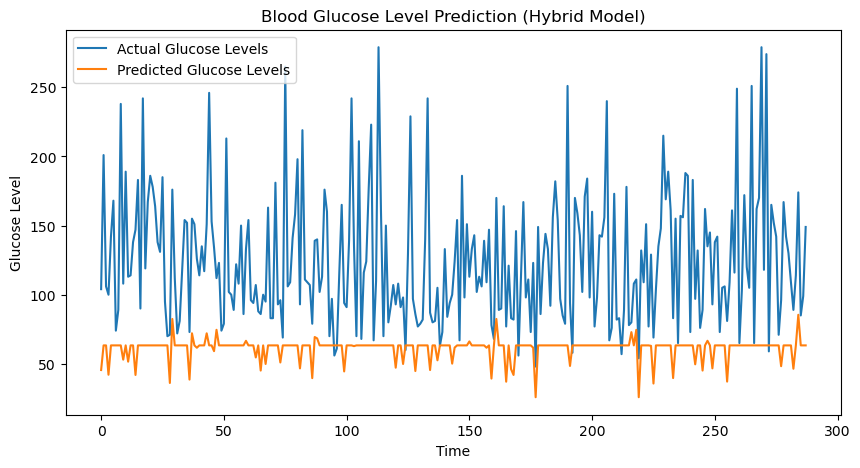

In [39]:
# Create a DataFrame for training
df_train = pd.DataFrame({
    'white_box_predictions': white_box_predictions,
    'actual_glucose_levels': actual_glucose_levels
})

# Features and target
X = df_train[['white_box_predictions']]
y = df_train['actual_glucose_levels']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the XGBoost regressor (Black Box Model)
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions using the black box model
black_box_predictions = model.predict(X_test)

# Combine white box and black box predictions
final_predictions = (X_test.flatten() + black_box_predictions) / 2

# Evaluate the combined model
mse = mean_squared_error(y_test, final_predictions)
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual Glucose Levels')
plt.plot(final_predictions, label='Predicted Glucose Levels')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Glucose Level')
plt.title('Blood Glucose Level Prediction (Hybrid Model)')
plt.show()
